## Optimization Project 3 <br>
### Team of Consultants- <br>
1. Yi-Ting Huang <br>
2. Hyeon Gu Kim <br>
3. Ayush Malani <br>
4. Allie Touchstone

## Importing Libraries

In [115]:
import numpy as np
import pandas as pd
import seaborn as sns   
import matplotlib.pyplot as plt  
sns.set(color_codes=True) 
%matplotlib inline 


import gurobipy as gp
from scipy.optimize import minimize
from statistics import mean


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### Setting Time Limit

In [116]:
# Setting the time limit

time_limit = 3600

In [117]:
# Reading the training data

train_df = pd.read_csv("training_data.csv")

# Reading the test data

test_df = pd.read_csv("test_data.csv")

In [118]:
train_df.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [119]:
test_df.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,7.107949,-2.047008,0.260132,-0.785152,0.384576,-0.137613,-0.364566,-1.941253,-0.108180,-0.339223,...,-0.522194,1.861897,0.124511,1.144071,0.128179,-0.467972,-1.085601,0.659670,0.514719,0.806656
1,5.796272,-1.354328,-1.289884,1.321533,-0.091165,-1.021874,0.686778,0.089737,-0.398371,-0.261740,...,-0.502578,0.584476,0.680703,0.046788,0.569681,-1.099062,-0.069656,0.709273,-0.848665,0.996168
2,1.598651,0.502205,1.062887,1.460733,-1.506403,0.721664,0.528921,-0.699541,-0.270331,-2.544812,...,-0.125195,-1.292924,0.411785,-0.164210,-2.407403,-1.132500,0.452923,-0.945541,0.126523,-0.972075
3,2.532953,0.222381,-0.960747,-0.113762,1.935927,0.969387,-1.641403,0.026647,0.747138,-1.571784,...,-0.546915,-0.192517,0.603420,-0.277331,-1.451419,0.220775,0.474954,-0.160109,0.188047,-1.711229
4,0.590685,1.209949,1.586874,-0.694784,-0.226370,-0.152108,0.772356,-0.573741,-0.992492,-0.646661,...,-0.982236,-1.407777,0.094211,0.159960,-0.901612,-1.653122,0.393518,0.702539,0.552663,-0.773646


In [120]:
print(train_df.shape)
print(test_df.shape)

(250, 51)
(50, 51)


# Q2

## Creating function to return optimal coefficients of independent variables

In [121]:
def olsoptimal(df,k,n):
    
    # creating the variables m = number of variables and n = number of observations
    m = df.shape[1] - 1
#     n = df.shape[0]

    # creating a dataframe with all columns as independent variables and converting it into an array
    # Also creating an array for the dependent variable
    
    X_df = df.drop(columns=['y'])
    y_array = np.array(df['y'])
    X = np.array(X_df)

    X_matrix = np.zeros((n,m+1))

    X_matrix[:,0] = 1
    X_matrix[:,1:] = X
    
    # Creating X transpose multiplied by X matrix and putting it in left corner of Q matrix
    XTX = (X_matrix.T @ X_matrix)

    Q_matrix = np.zeros((2*m + 1,2*m + 1))

    Q_matrix[0:51,0:51] = XTX
    
    
    # Objective vector of coefficients for m+1 betas and m binary decision variables
    obj = np.zeros((2*m+1))
    obj[0:m+1] = -2*(y_array.T @ X_matrix)

    # Setting big M as 200
    M = 200
    
    # Creating the constraint matrix with 2m+1 constraints for 2m+1 variables. 
    # 1 constraint to ensure that maximum k variables are selected
    # m constraints for the m betas being less than or equal to Mz (where z is the binary decision variable)
    # m constraints for the m betas being greater than or equal to -Mz (where z is the binary decision variable)
    
    A = np.zeros((2*m+1,2*m+1))

    A[0,:][-m:] = 1

    for i in range(0,50):
        A[1+i,[1+i,-m+i]] = [1,-M]

    for i in range(0,50):
        A[m+1+i,[1+i,-m+i]] = [1,M]

    sense = ['<'] + ['<']*m + ['>']*m
    b = np.array([k]+[0]*(2*m))

    vtype = ['C']*(m+1) + ['B']*m
    lb = -M
    
    
    miqpMod = gp.Model()
    miqpMod_x = miqpMod.addMVar(len(obj),vtype=vtype, lb=lb)
    miqpMod_con = miqpMod.addMConstrs(A, miqpMod_x, sense, b)
    miqpMod.setMObjective(Q_matrix,obj,0,sense=gp.GRB.MINIMIZE)

    miqpMod.Params.OutputFlag = 0 

    # Setting the time limit specified at the top of the code
    miqpMod.Params.TimeLimit = time_limit
    miqpMod.optimize()
    
    
    betas = miqpMod_x.x[:(m+1)]
    beta_columns = [1] + list(X_df.columns)
    beta_df = pd.DataFrame(zip(beta_columns,betas),columns=['variable','coefficient'])
    beta_df = beta_df[beta_df['coefficient']!=0]

    z_decision = miqpMod_x.x[(m+1):]

    
    sq_error = miqpMod.objVal + (y_array.T @ y_array)
    
    return betas

In [122]:
# Checking this function for k=10 
# It returns the betas of the OLS model

beta_k10 = olsoptimal(train_df,10,train_df.shape[0])
beta_k10

array([ 0.97252408,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -2.30820726,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.51832612, -0.20416201,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.55914318,  0.86697336,
        0.        , -1.31191942,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.4081653 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.78147489,  0.        ,  0.88738292, -0.28229213,  0.        ,
        0.        ])

## Function to cross-validate the optimization model and check for SSE over different values of k (number of parameters selected)

In [123]:
def cv_ols(df):
    
    # Creating an empty list to store total Sum of Squared Errors
    sse_list = []
    
    # Looping for different values of k ranging from 5, 10, 15....50
    for k in range(5,51,5):
        error_list = []
        for cv in range(10):
            # Extracting 10 random indexes to subset the training data into validation and training sets
            
            random_index = np.random.choice(range(0,df.shape[0]),int(df.shape[0]/10), replace = False)

            X_holdout = df.drop(columns=['y']).iloc[random_index]
            y_holdout = df['y'].iloc[random_index]

            X_train = df.drop(random_index,axis=0)
            X_train_dep = X_train.drop(columns=['y'])
            y_train = df['y'].drop(random_index,axis=0)

            # n stores the total number of observations in the dataframe that is being used to create the model
            n = X_train.shape[0]
            
            # Using our previously defined function to get the beta values after cross validation
            betas = olsoptimal(X_train,k,n)

            # Creating an X_matrix to store all independent variables from the holdout set
            # Will use these values to predict the dependent variable by multiplying it with the betas obtained above
            X = np.array(X_holdout)
            X_matrix = np.zeros((X_holdout.shape[0],X_holdout.shape[1]+1))

            X_matrix[:,0] = 1
            X_matrix[:,1:] = X


            y_pred = list(X_matrix @ betas)
            
            # Getting the residuals and squaring it
            residual = y_pred - y_holdout
            sse = sum(residual**2)
            error_list.append(sse)
            
        # Storing the sum of squared errors in a list    
        sse_list.append(sum(error_list))

    return sse_list

In [124]:
# Using the function to return the errors
chk_errors = cv_ols(train_df)

In [125]:
# Creating a datframe with k values and corresponding errors
k_errors = pd.DataFrame(zip(list(range(5,51,5)),chk_errors),columns=['k','SSE'])

In [126]:
# k_errors.to_csv('k_errors.csv')

In [127]:
# Storing the best value of k in a separate variable
best_k = k_errors.iloc[k_errors['SSE'].idxmin()]['k']

In [128]:
print("Value of k that gives the lowest SSE is: ",best_k)

Value of k that gives the lowest SSE is:  10.0


Text(0.5, 1.0, 'Different Values of k and SSEs')

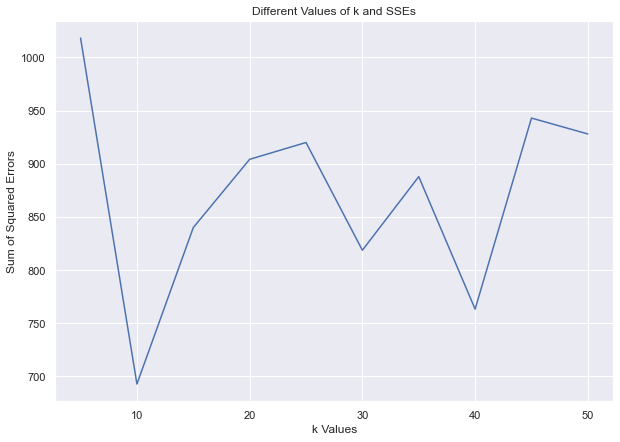

In [129]:
fig = plt.figure(figsize = (10, 7))

sns.lineplot(x='k',y='SSE',data=k_errors)

plt.xlabel("k Values")
plt.ylabel("Sum of Squared Errors")
plt.title("Different Values of k and SSEs")

Text(0.5, 1.0, 'Coefficients Selected for k=10')

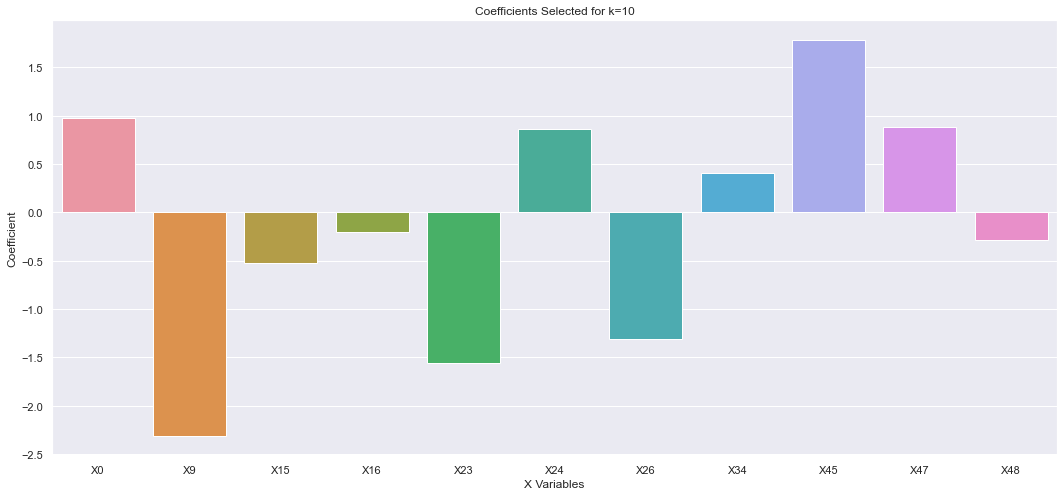

In [161]:
# Graph showing the coefficients of the variables selected

fig = plt.figure(figsize = (18, 8))

opt_k_betas= olsoptimal(train_df,best_k,train_df.shape[0])
beta_columns = ['X0'] + list(train_df.drop(columns=['y']).columns)
beta_df = pd.DataFrame(zip(beta_columns,opt_k_betas),columns=['variable','coefficient'])
beta_df = beta_df[beta_df['coefficient']!=0]


sns.barplot(x='variable',y='coefficient',data=beta_df)

plt.xlabel("X Variables")
plt.ylabel("Coefficient")
plt.title("Coefficients Selected for k=10")

# Q3

## Using best k to get best coefficients, and predicting y values using Test Data

In [131]:
# Running optimization model with best k to fetch optimal coefficients 

best_betas = olsoptimal(train_df,10,train_df.shape[0])

# Using these beta values to predict y values of test set

X_test = test_df.drop(columns=['y'])
X = np.array(X_test)
X_matrix = np.zeros((X_test.shape[0],X_test.shape[1]+1))

X_matrix[:,0] = 1
X_matrix[:,1:] = X


y_pred = list(X_matrix @ best_betas)

# Getting the residuals and squaring it
residual = y_pred - test_df['y']
sse = round(sum(residual**2),3)
mse = round(mean(residual**2),3)

print("List of Predicted y values is: ",list(y_pred))
print("Sum of Squared Error is: ",sse)
print("Mean Squared Error is: ",mse)

List of Predicted y values is:  [6.1798587814430554, 5.095242986840433, 3.285595322405012, 3.758485387661267, -0.3329752585827508, -5.142736834668355, -3.1445435672467648, -1.2380628758189638, 1.385110927664297, -0.4417385447810933, -1.6950022467195125, 2.730350268182777, 0.7474490344778995, -0.9719223177248243, -0.6868152824269118, 8.045223814607212, -7.94698471054204, 3.8906397391997847, -4.581429188968253, -3.2199208247154, -2.1621145380309494, 3.2168631773246266, -3.1981053263742094, 0.19740730625328085, -2.359888443862836, -0.4199988547491156, -1.912521602735868, -3.324185867280881, -3.1417097171886748, -3.5537932361104754, -1.8084254250491, -0.3713430055651432, 1.8670808021748784, 5.049278862839073, -1.800056141073267, 3.0942767463995766, 4.3815430904322685, 2.6988626993835316, 1.613288597544751, 5.975846372424302, -1.197358299810574, 5.223254198055277, -5.848998908490292, -1.1446152790055186, 4.518029975345612, 4.187748655603145, 4.120460083021932, 0.6148380886005063, 1.95723245

# Q4

## Finding optimal parameters and predicting y using Lasso Regression after Cross Validation

In [143]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import KFold

In [133]:
train_y = train_df.iloc[:, 0]
train_X = train_df.iloc[:, 1:]

test_y = test_df.iloc[:, 0]
test_X = test_df.iloc[:, 1:]


n = train_X.shape[0]
m = train_X.shape[1]

In [144]:
cv = KFold(n_splits=10, shuffle=False)

In [145]:
# Cross validating the Lasso Model with LassoCV for 10 folds

lasso_cv = LassoCV(cv=cv).fit(train_X, train_y)

In [146]:
# Lambda chosen by 10 CV:
lambda10CV = lasso_cv.alpha_
lambda10CV

0.07638765995113507

In [136]:
# Chosen variables index:
np.nonzero(lasso_cv.coef_)

(array([ 8, 10, 14, 15, 21, 22, 23, 25, 28, 32, 33, 38, 43, 44, 45, 46, 47],
       dtype=int64),)

In [137]:
lasso = Lasso(alpha=lambda10CV).fit(train_X, train_y)
yhat = lasso.predict(test_X)
mse_lasso = round(mean_squared_error(test_y, yhat),3)
print("Mean squared error using Lasso Regression is: ",mse_lasso)

Mean squared error using Lasso Regression is:  2.35


In [138]:
sse_lasso = round(sum((yhat - test_y)**2),3)

In [139]:
print("Sum of Squared errors using Lasso Regression is: ",sse_lasso)

Sum of Squared errors using Lasso Regression is:  117.482


## Comparing Errors of MIQP Optimized OLS and Lasso Regression

In [140]:
index_values = ['MSE','SSE']
comparison_df = pd.DataFrame({"Errors":index_values,"Optimized OLS":[mse,sse], "Lasso Regression":[mse_lasso,sse_lasso]})

comparison_df = comparison_df.set_index('Errors')
comparison_df

,Optimized OLS,Lasso Regression
Errors,,
MSE,2.337,2.350
SSE,116.827,117.482


Text(0.5, 1.0, 'Different Methods of k and SSEs')

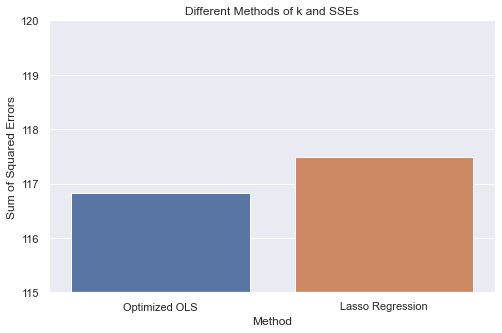

In [141]:
fig = plt.figure(figsize = (8, 5))

sns.barplot(x=comparison_df.columns,y=comparison_df.loc['SSE'].values)
plt.ylim(115,120)
plt.xlabel("Method")
plt.ylabel("Sum of Squared Errors")
plt.title("Different Methods of k and SSEs")